In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [38]:
def calcular_metricas(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    smape = 100 * np.mean(2 * np.abs(pred - real) / (np.abs(real) + np.abs(pred)))
    mape = 100 * np.mean(np.abs((real - pred) / real))
    r2 = r2_score(real, pred)
    metricas = pd.DataFrame({
        'Métrica': ['MAE', 'RMSE', 'sMAPE', 'MAPE', 'R2'],
        'Valor': [mae, rmse, f"{smape:.2f}%", f"{mape:.2f}%", f"{r2:.2f}"]
    })
    return metricas

In [39]:
df = pd.read_csv('../output/dataset_venta.csv')
df['fecha'] = pd.to_datetime(df['fecha'], format="%Y-%m-%d", errors='coerce')
df = df.groupby('fecha')['monto_recibido'].sum().reset_index()
df.rename(columns={'fecha':'ds','monto_recibido':'y'}, inplace=True)

df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['day_of_week'] = df['ds'].dt.dayofweek
df['quarter'] = df['ds'].dt.quarter

df.head()

,ds,y,year,month,day,day_of_week,quarter
0,2019-01-07,5651.05,2019,1,7,0,1
1,2019-01-08,4285.00,2019,1,8,1,1
2,2019-01-09,15455.00,2019,1,9,2,1
3,2019-01-10,5024.50,2019,1,10,3,1
4,2019-01-11,6350.50,2019,1,11,4,1


In [40]:
n = len(df)
train_size = int(n*0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train[['year', 'month', 'day', 'day_of_week', 'quarter']]
y_train = train['y']
X_test = test[['year', 'month', 'day', 'day_of_week', 'quarter']]
y_test = test['y']

In [41]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

predicciones = rf.predict(X_test)


In [42]:
metricas_rf = calcular_metricas(y_test, predicciones)
print(metricas_rf)

  Métrica       Valor
0     MAE  617.494554
1    RMSE  798.435043
2   sMAPE      34.42%
3    MAPE      45.57%
4      R2       -0.10


In [43]:
line_real = dict(color='#000000', linewidth=1.2, label='Datos reales')
line_pred = dict(color='#1f77b4', linewidth=1.2, linestyle='--', label='Predicción')
grid_opts = dict(linestyle='--', alpha=0.25)

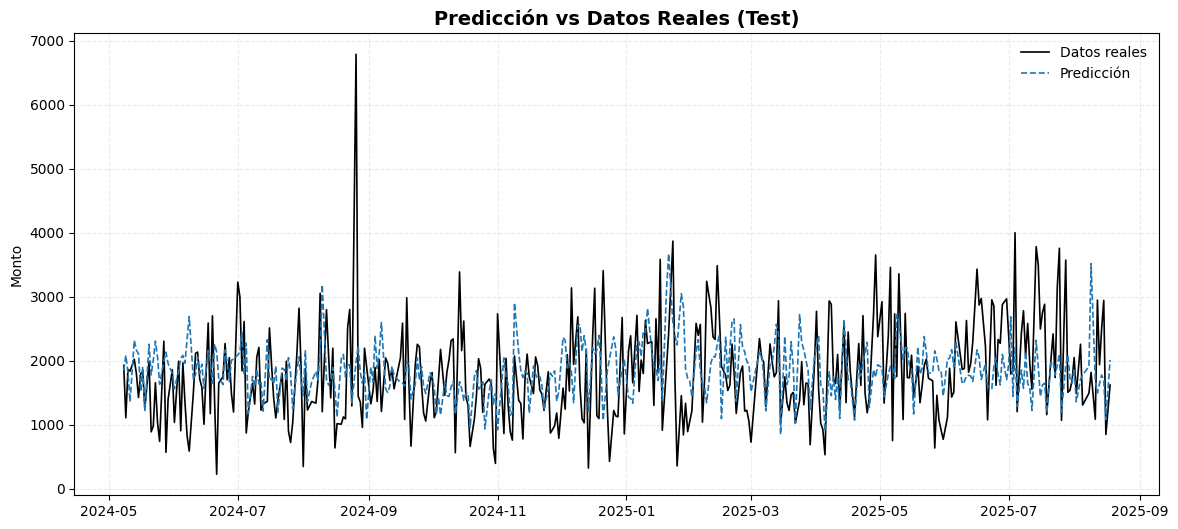

In [44]:
# Gráfico de predicción vs real
plt.figure(figsize=(14,6))
plt.plot(test['ds'], test['y'], **line_real)
plt.plot(test['ds'], predicciones, **line_pred)
plt.title('Predicción vs Datos Reales (Test)', fontsize=14, weight='bold')
plt.ylabel('Monto')
plt.grid(**grid_opts)
plt.legend(frameon=False)
plt.show()

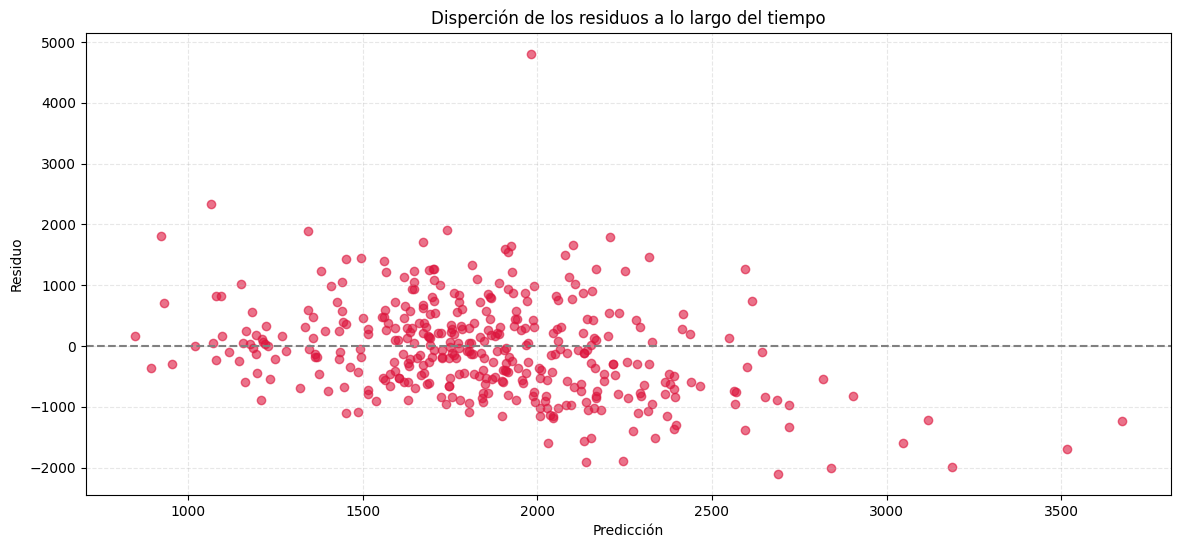

In [53]:
# Graficar residuos
residuos = y_test.values - predicciones

plt.figure(figsize=(14,6))
plt.scatter(predicciones, residuos, alpha=0.6, color='crimson')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Disperción de los residuos a lo largo del tiempo")
plt.xlabel('Predicción')
plt.ylabel('Residuo')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

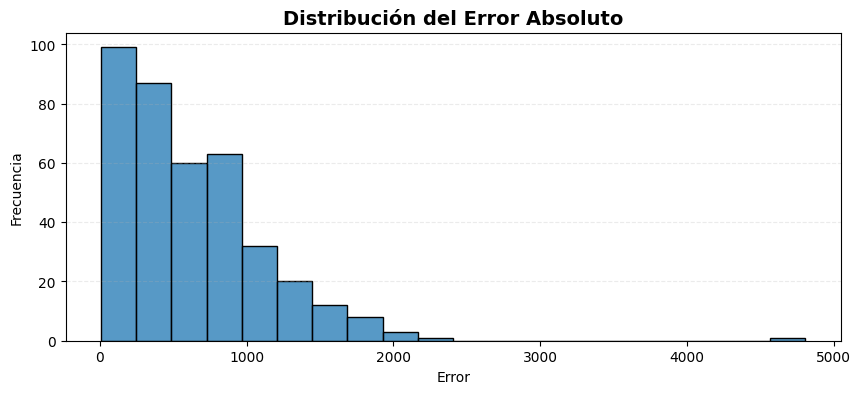

In [52]:
plt.figure(figsize=(10,4))
sns.histplot(abs(residuos), bins=20, color='#1f77b4', edgecolor='black')
plt.title('Distribución del Error Absoluto', fontsize=14, weight='bold')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.show()

In [47]:
# Resultado de las predicciones
resultado_rf = pd.DataFrame({
    'ds': test['ds'].values,
    'real': y_test.values,
    'prediccion': predicciones,
    'residuo': residuos
})
resultado_rf.tail(10)

,ds,real,prediccion,residuo
376,2025-08-05,1306.50,1775.9850,469.4850
377,2025-08-08,1493.00,1911.6665,418.6665
378,2025-08-09,1817.50,3515.7007,1698.2007
379,2025-08-11,1085.00,1690.0076,605.0076
380,2025-08-12,2946.75,1494.5560,1452.1940
381,2025-08-13,1937.00,1641.1930,295.8070
382,2025-08-14,2498.00,1776.7252,721.2748
383,2025-08-15,2942.00,1690.1194,1251.8806
384,2025-08-16,846.50,1079.6754,233.1754
385,2025-08-18,1619.50,2012.0562,392.5562


In [48]:
# Exportar resultados
resultado_rf.to_csv(f'../output/prediccion_random_forest.csv', index=False)
print(f"✅ Archivo exportado: prediccion_random_forest.csv")


✅ Archivo exportado: prediccion_random_forest.csv
